In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)

In [2]:
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

image_file=get_pkg_data_filename('/Users/marxena/Desktop/LTTest/iejr03n4q_flt.fits')

fits.info(image_file)

Filename: /Users/marxena/Desktop/LTTest/iejr03n4q_flt.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     298   ()      
  1  SCI           1 ImageHDU       211   (513, 512)   float32   
  2  ERR           1 ImageHDU        48   (513, 512)   float32   
  3  DQ            1 ImageHDU        40   (513, 512)   int16   
  4  D2IMARR       1 ImageHDU        16   (64, 32)   float32   
  5  D2IMARR       2 ImageHDU        16   (64, 32)   float32   
  6  WCSDVARR      1 ImageHDU        16   (64, 32)   float32   
  7  WCSDVARR      2 ImageHDU        16   (64, 32)   float32   
  8  HDRLET        1 NonstandardExtHDU     21   (57600,)      
  9  WCSCORR       1 BinTableHDU     59   7R x 24C   [40A, I, A, 24A, 24A, 24A, 24A, D, D, D, D, D, D, D, D, 24A, 24A, D, D, D, D, J, 40A, 128A]   
 10  HDRLET       10 NonstandardExtHDU     21   (57600,)      


(512, 513)


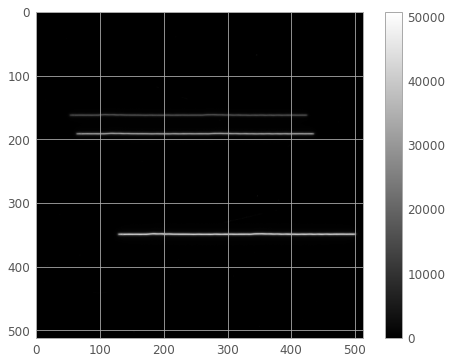

In [3]:
image_data = fits.getdata(image_file, ext=1)

print(image_data.shape)
plt.figure()
plt.imshow(image_data, cmap='gray')
plt.colorbar()

In [4]:
image_file = get_pkg_data_filename('/Users/marxena/Desktop/LTTest/iejr03n4q_flt.fits')
hdul = fits.open(image_file)
hdul[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
ORIGIN  = 'HSTIO/CFITSIO March 2010' / FITS file originator                     
DATE    = '2022-01-28' / date this file was written (yyyy-mm-dd)                
NEXTEND =                   10 / Number of standard extensions                  
FILENAME= 'iejr03n4q_flt.fits' / name of file                                   
FILETYPE= 'SCI      '          / type of data found in data file                
                                                                                
TELESCOP= 'HST'             

In [5]:
start=hdul[0].header['EXPSTART']
end=hdul[0].header['EXPEND']
time=hdul[0].header['EXPTIME']

print(start)
print(end)
print(time)

59486.59623221
59486.59648681
22.0


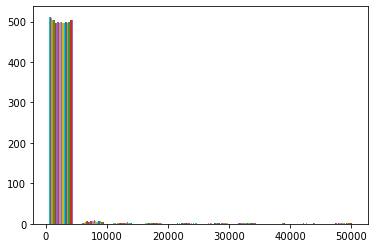

[[-3.678902    1.1724665  -6.7333026  ...  9.848079   -4.3649063
  -5.164156  ]
 [ 6.6339827   4.8833814  -2.3716967  ... -1.2832175   1.3009351
   2.5230856 ]
 [ 3.9712222  -1.1082224  -2.3557906  ...  3.6377485  -0.8291172
  -0.207451  ]
 ...
 [ 5.100014   -0.6523088   2.910043   ...  7.134196    3.3210053
   5.680383  ]
 [ 2.8754346   1.0825907   7.4253707  ...  6.2931247   6.5894003
   3.1765025 ]
 [ 2.633591   -0.57068396 -1.1177411  ...  3.230411    0.40557143
   5.2917924 ]]


In [74]:
plt.hist(image_data)
plt.show()
print(image_data)

In [7]:
#print(len(image_data))

12060.76611328125


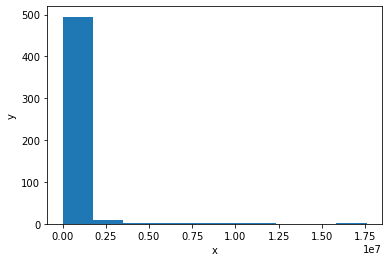

In [77]:
import matplotlib.pyplot as plt
import numpy as np
x=np.zeros(len(image_data))
for n in range(len(image_data)):
        x[n] = np.sum(image_data[n][:])
        
plt.hist(x)
print(np.median(x))

#plt.hist(x, density=True, bins=30)  
plt.ylabel('y')
plt.xlabel('x');

bg=np.median(x)

In [10]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
from astropy.stats import sigma_clip
from scipy import optimize, signal
import pickle
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import statistics
import pickle
import glob
from astropy.io import fits
import warnings
warnings.filterwarnings("ignore")
from astropy.visualization import simple_norm
import matplotlib.patches as patches

### personally developed pipeline scripts
#import wfc3_extract
#import mjd_bjd
#import wfc3_systematics
#import bat_model
#import wfc3_mcmc
#import wfc3_spec_trace
#import binning
#import wfc3_extract_spec

def wfc3_extract(hist_med, plnm='W79', numxaps=5, numyaps=10):

#---Working Directory----------------------------------------------   
#     fpath = /Users/marxena/Desktop/LTTest
    fpath = '/Users/marxena/Desktop/LTTest/' 
#     filenames = '/Users/marxena/Desktop/LTTest/iejr03n4q_flt.fits'
    filenames = glob.glob(fpath + '*.fits')

#     filenames = glob.glob(fpath + 'LTTest/' + '*iejr03n4q_flt.fits')
    filenames = sorted(filenames)
   # print(filenames)

#---LOOP OVER EACH FITS FILE---------------------------------------
    
    for i in range(0, len(filenames)):
        hdulist = fits.open(filenames[i])
        #print(hdulist)

#-------make the arrays we will need-------------------------------
        if i == 0:
            img_ax = np.asarray(hdulist[1].data)
            subarray=len(img_ax)
            subarray2 = len(img_ax[0])
            nsamp=1
            print (str(len(filenames))+'files and'+str(nsamp)+'samples each')
            nsamp=int(nsamp)
            temp=np.zeros(shape=(subarray, subarray2))
            images=np.zeros(shape=(subarray, subarray2, len(filenames)))
            time=np.zeros(len(filenames))
            raDeg=np.zeros(len(filenames))
            decDeg=np.zeros(len(filenames))
            wlc=np.zeros(shape=(len(filenames), numyaps, numxaps))
            scan_ang=np.zeros(len(filenames))
            ndrwhite=np.zeros(shape=(numyaps, numxaps))  
            flux=np.zeros(shape=(numyaps, numxaps))
            error=np.zeros(shape=(numyaps, numxaps))
            diff=np.zeros(shape=(numyaps, numxaps))
            wlc_error=np.zeros(shape=(len(filenames), numyaps, numxaps))
        else: 
            pass
                    
#-------get info from headers----------------------------------------
        scidata=hdulist[1].data
        err=hdulist[2].data
        
        expstart=hdulist[0].header['EXPSTART']
        expend=hdulist[0].header['EXPEND']
        exptime=hdulist[0].header['EXPTIME']
        scan_ang[i]=hdulist[0].header['SCAN_ANG']
        scanlen=hdulist[0].header[ 'SCAN_LEN']
        raDeg = hdulist[0].header['RA_TARG']
        decDeg = hdulist[0].header['DEC_TARG']
        time[i]=0.5*(expend+expstart)
        if i ==0:
            xybox=getbox(scidata) #THIS GETS A BOX THE SIZE OF THE SPEC
            x_range=xybox[1]+1-xybox[0]
            y_range=xybox[3]+1-xybox[2]
            x_cen=np.floor((xybox[1]+1-xybox[0])/2.)
            y_cen=np.floor((xybox[3]+1-xybox[2])/2.)

#-------flat field and background--------------------------------------
        scidata, images = background_and_flat(scidata, images, hist_med, i)
    
        for aprx in range(0, numxaps):
            xwidth=x_range+aprx
            
            for apry in range(0, numyaps):
                ff=np.sum(scidata[xybox[2]-apry:xybox[3]+1+apry, xybox[0]-aprx:xybox[1]+1+aprx])
                er=np.sum(err[xybox[2]-apry:xybox[3]+1+apry, xybox[0]-aprx:xybox[1]+1+aprx]**2.)
                flux[apry, aprx] = ff
                error[apry, aprx]=er
       # wlc_error[i,:, :]=np.sum(error, axis=0)**0.5
        diff=np.zeros(shape=(numyaps, numxaps))
        wlc[i, :, :]=diff
        
    print('wlc', wlc)
    plt.figure()
    plt.errorbar(time,  wlc[:,0,0], yerr=wlc_error[:,0,0], fmt='o', color='k')
    plt.xlabel('Time ($MJD_{UTC}$)')
    plt.ylabel('Flux (e$^-$)')
    plt.title('WFC3 Raw Light curve')
    plt.show()
    
    #outpath = fpath+'LTT1445_outpath/'
    #fileObject = open(outpath+'wlc_extract_out', 'wb')
#     pickle.dump([time, wlc, wlc_error, raDeg, decDeg, scidata, 
#                  xybox, fileObject])
#     fileObject.close()
    
    return time, wlc, wlc_error, raDeg, decDeg, scidata, xybox


def background_and_flat(scidata, images, hist_med, i):
#---define columns at the edge of the image to mask--------------------------------
#     cols1 = np.arange(0,50)
#     cols2 = np.arange(450, 512)
#     edges=np.append(cols1,cols2)
#     m = np.zeros_like(scidata)
#     m[:,edges] = 1
#     m[edges, :] = 1
#     scidata=np.ma.masked_array(scidata, m)         
#---get rid of cosmic rays---------------------------------------------------------
    scidata = sigma_clip(scidata, sigma=7)
#---background box-----------------------------------------------------------------
#     backbox=scidata[xybox[2]-100:xybox[2]-50, :]
#     backbox=scidata[xybox[3]+50:xybox[3]+100, :] #pulling bg in form scidata[ymin, ymax, xmin, xmax]
   
#     bkgd = backbox.mean(axis=0)
#     print('background',bkgd)
#     bkgd = sp.signal.medfilt(bkgd,31)
#     bkgd = np.array([bkgd,]*522)
    bkgd = hist_med #set this as the median from the histogram for bkgrd
    
    scidata = scidata-bkgd
    print('scidata - bkgd', scidata)
#     scidata = sigma_clip(scidata, sigma=5)
#     print('scidata shape:', np.shape(scidata))
#     print('images shape:', np.shape(images))
#     print('images_section shape:', np.shape(images[:,:,j,i]))
    images[:,:,i]=scidata


    return scidata, images

In [95]:
def getbox(scidata):
    #box1 = [80,180,300,400,400,300,512,400]
    #box1 = [xmin,xmax,yminbot,ymaxbot,ymintop,ymaxtop]
    #box1 = [80,500,300,400,400,300,512,440]
    box1 = [128,503,348,348,400,354,354]
    tried = 1
    holdy=np.zeros(100)
    holdx=np.zeros(100)
    for xx in range(box1[0],box1[1],10): #CHANGE the 80 & 180 to span pixels that are on 
                                #either side of the left edge of your spectra 
                                #without encompassing contamination sources
        for yy in range(box1[2],box1[3]): #CHANGE the 0 & 250 to span pixels that are on
                                #either side of the bottom edge of your spectra
                                #without encompassing contamination sources
            ybot=yy
            if scidata[yy,xx] > 4*np.mean(scidata):
                break
        holdy[int((xx-box1[0])/10-1)]=ybot #CHANGE 80 to min value chosen for xx
    holdy = np.array(list(filter(lambda num: num != 0, holdy)))
    ybot=int(np.median(holdy))
    
    for xx in range(box1[0],box1[1],10): #CHANGE the 80 & 180 to span pixels that are on 
                                #either side of the left edge of your spectra 
                                #without encompassing contamination sources
        for yy in range(box1[4],box1[5], -1): #CHANGE the 450 & 0 to span pixels that are 
                                #on either side of the top edge of your spectra
                                #without encompassing contamination sources
            ytop=yy
            if scidata[yy,xx] > 2*np.mean(scidata):
                break
        holdy[int((xx-box1[0])/10-1)]=ytop #CHANGE 80 to min value chosen for xx
    holdy = np.array(list(filter(lambda num: num != 0, holdy)))
    ytop=int(np.median(holdy))

    #for yy in range(ybot,ytop, tried):
    for yy in range(345,355, tried):
        for xx in range(box1[0],box1[1]): #CHANGE the 0 & 350 to span pixels that are on 
                                #either side of the left edge of your spectra 
                                #without encompassing contamination sources
            xleft=xx
            if scidata[yy,xx] > 2*np.mean(scidata):
                break
        #holdx[int((yy-ybot)/(tried)-1)]=xleft
        holdx[int((yy-345)/(tried)-1)]=xleft
    holdx = np.array(list(filter(lambda num: num != 0, holdx)))
    xleft=int(np.median(holdx))
    #for yy in range(ybot,ytop, tried):
    for yy in range(345,355, tried):
        for xx in range(box1[6],box1[7], -1): #CHANGE the 250 & 0 to span pixels that are on 
                                #either side of the right edge of your spectra 
                                #without encompassing contamination sources
            xright=xx
            if scidata[yy,xx] > 2*np.mean(scidata):
                break
        #holdx[int((yy-ybot)/(1)-tried)]=xright
        holdx[int((yy-345)/(1)-tried)]=xright
    holdx = np.array(list(filter(lambda num: num != 0, holdx)))
    xright=int(np.median(holdx))
    global xybox
    xybox=np.array([xleft, xright, ybot, ytop])

    print('xybox(xleft, xright, ybot, ytop)=', xybox)
    return xybox



def getbox2(scidata):
 #box1 = [xmin,xmax,yminbot,ymaxbot,ymintop,ymaxtop]
    box2 = [62,440,347,347,354,354]
    tried = 1
    holdy=np.zeros(100)
    holdx=np.zeros(100)
    for xx in range(box2[0],box2[1],10): #CHANGE the 80 & 180 to span pixels that are on 
                                #either side of the left edge of your spectra 
                                #without encompassing contamination sources
        for yy in range(box2[2],box2[3]): #CHANGE the 0 & 250 to span pixels that are on
                                #either side of the bottom edge of your spectra
                                #without encompassing contamination sources
            ybot=yy
            if scidata[yy,xx] > 4*np.mean(scidata):
                break
        holdy[int((xx-box2[0])/10-1)]=ybot #CHANGE 80 to min value chosen for xx
    holdy = np.array(list(filter(lambda num: num != 0, holdy)))
    ybot=int(np.median(holdy))
    
    for xx in range(box2[0],box2[1],10): #CHANGE the 80 & 180 to span pixels that are on 
                                #either side of the left edge of your spectra 
                                #without encompassing contamination sources
        for yy in range(box2[4],box2[5], -1): #CHANGE the 450 & 0 to span pixels that are 
                                #on either side of the top edge of your spectra
                                #without encompassing contamination sources
            ytop=yy
            if scidata[yy,xx] > 2*np.mean(scidata):
                break
        holdy[int((xx-box2[0])/10-1)]=ytop #CHANGE 80 to min value chosen for xx
    holdy = np.array(list(filter(lambda num: num != 0, holdy)))
    ytop=int(np.median(holdy))

    #for yy in range(ybot,ytop, tried):
    for yy in range(185,195, tried):
        for xx in range(box2[0],box2[1]): #CHANGE the 0 & 350 to span pixels that are on 
                                #either side of the left edge of your spectra 
                                #without encompassing contamination sources
            xleft=xx
            if scidata[yy,xx] > 2*np.mean(scidata):
                break
        #holdx[int((yy-ybot)/(tried)-1)]=xleft
        holdx[int((yy-185)/(tried)-1)]=xleft
    holdx = np.array(list(filter(lambda num: num != 0, holdx)))
    xleft=int(np.median(holdx))
    #for yy in range(ybot,ytop, tried):
    for yy in range(185,195, tried):
        for xx in range(box2[6],box2[7], -1): #CHANGE the 250 & 0 to span pixels that are on 
                                #either side of the right edge of your spectra 
                                #without encompassing contamination sources
            xright=xx
            if scidata[yy,xx] > 2*np.mean(scidata):
                break
        #holdx[int((yy-ybot)/(1)-tried)]=xright
        holdx[int((yy-185)/(1)-tried)]=xright
    holdx = np.array(list(filter(lambda num: num != 0, holdx)))
    xright=int(np.median(holdx))
    global xybox2
    xybox2=np.array([xleft, xright, ybot, ytop])

    print('xybox2(xleft2, xright2, ybot2, ytop2)=', xybox2)
    return xybox2
#---------------------------------------------------------------------------
#---3rd box-----------------------------------------------------------------
#----------------------------------------------------------------------------


def getbox3(scidata):
    box3 = [45,430,145,180,180,145,440,360]
    tried = 1
    holdy=np.zeros(100)
    holdx=np.zeros(100)
    for xx in range(box3[0],box3[1],10): #CHANGE the 80 & 180 to span pixels that are on 
                                #either side of the left edge of your spectra 
                                #without encompassing contamination sources
        for yy in range(box3[2],box3[3]): #CHANGE the 0 & 250 to span pixels that are on
                                #either side of the bottom edge of your spectra
                                #without encompassing contamination sources
            ybot=yy
            if scidata[yy,xx] > 4*np.mean(scidata):
                break
        holdy[int((xx-box3[0])/10-1)]=ybot #CHANGE 80 to min value chosen for xx
    holdy = np.array(list(filter(lambda num: num != 0, holdy)))
    ybot=int(np.median(holdy))
    
    for xx in range(box3[0],box3[1],10): #CHANGE the 80 & 180 to span pixels that are on 
                                #either side of the left edge of your spectra 
                                #without encompassing contamination sources
        for yy in range(box3[4],box3[5], -1): #CHANGE the 450 & 0 to span pixels that are 
                                #on either side of the top edge of your spectra
                                #without encompassing contamination sources
            ytop=yy
            if scidata[yy,xx] > 2*np.mean(scidata):
                break
        holdy[int((xx-box3[0])/10-1)]=ytop #CHANGE 80 to min value chosen for xx
    holdy = np.array(list(filter(lambda num: num != 0, holdy)))
    ytop=int(np.median(holdy))

    #for yy in range(ybot,ytop, tried):
    for yy in range(155,170, tried):
        for xx in range(box3[0],box3[1]): #CHANGE the 0 & 350 to span pixels that are on 
                                #either side of the left edge of your spectra 
                                #without encompassing contamination sources
            xleft=xx
            if scidata[yy,xx] > 2*np.mean(scidata):
                break
        #holdx[int((yy-ybot)/(tried)-1)]=xleft
        holdx[int((yy-155)/(tried)-1)]=xleft
    holdx = np.array(list(filter(lambda num: num != 0, holdx)))
    xleft=int(np.median(holdx))
    #for yy in range(ybot,ytop, tried):
    for yy in range(155,170, tried):
        for xx in range(box3[6],box3[7], -1): #CHANGE the 250 & 0 to span pixels that are on 
                                #either side of the right edge of your spectra 
                                #without encompassing contamination sources
            xright=xx
            if scidata[yy,xx] > 2*np.mean(scidata):
                break
        #holdx[int((yy-ybot)/(1)-tried)]=xright
        holdx[int((yy-155)/(1)-tried)]=xright
    holdx = np.array(list(filter(lambda num: num != 0, holdx)))
    xright=int(np.median(holdx))
    global xybox3
    xybox3=np.array([xleft, xright, ybot, ytop])

    print('xybox3(xleft3, xright3, ybot3, ytop3)=', xybox3)
    return xybox3

In [96]:
#MJD_UTC, flux, flux_err, raDeg, decDeg, scidata, xybox=wfc3_extract(bg)

from astropy.utils.data import get_pkg_data_filename
fpath='/Users/marxena/Desktop/LTTest/iejr03n4q_flt.fits'
mist = glob.glob(fpath)
mist = sorted(mist)
image_file = get_pkg_data_filename(mist[0])
image_data = fits.getdata(image_file, ext=0)
x = np.zeros(len(image_data))
for n in range(len(image_data)):
    x[n] = np.sum(image_data[n][:])
hist_med = np.median(x)

MJD_UTC, flux, flux_err, raDeg, decDeg, scidata, xybox = wfc3_extract(hist_med)

from astropy.visualization import simple_norm
import matplotlib.patches as patches
# Create an ImageNormalize object
norm = simple_norm(scidata, 'sqrt', min_cut=0)


# Display the image

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(scidata, origin='lower', norm=norm)

#First order spectra search
rect1 = patches.Rectangle((xybox[0],xybox[2]),(xybox[1]-xybox[0]),(xybox[3]-xybox[2]), 
                          fill=False, ec='b', linewidth=2)
rect2 = patches.Rectangle((60,185),(380),(10), fill=False, ec='r', linewidth=2)
# #Background region
rect3 = patches.Rectangle((50,155),(380),(10), fill=False, ec='r', linewidth=2)
rect2 = patches.Rectangle((xybox2[1],xybox2[2]),(xybox2[1]-xybox2[1]),(xybox2[3]-xybox2[2]),
                          fill=False, ec='r', linewidth=2)
#Background region
rect3 = patches.Rectangle((xybox3[0],xybox3[2]),(xybox3[1]-xybox3[0]),(xybox3[3]-xybox3[2]),
                           fill=False, ec='r', linewidth=2)

ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)

fig.colorbar(im, label='Electrons')
ax.set_xlabel('Dispersion direction', fontsize=18)
ax.set_ylabel('Scanning direction', fontsize=18)
fig.show()
print((xybox[0],xybox[2]),(xybox[1]-xybox[0]),(xybox[3]-xybox[2]))
print(getbox(scidata))

9files and1samples each


UnboundLocalError: local variable 'ybot' referenced before assignment

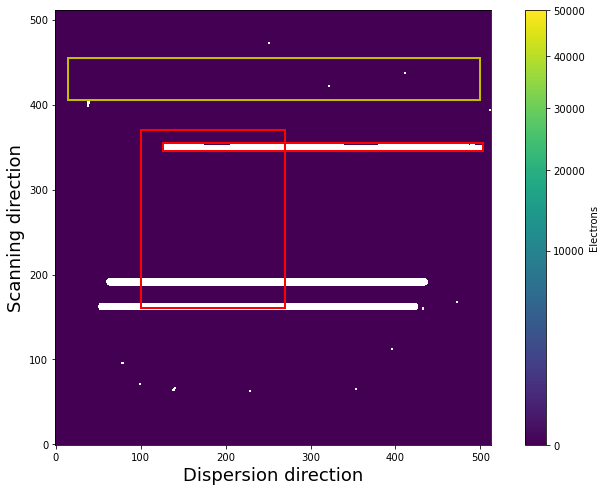

In [92]:
###View NDR of first image of first visit

# Create an ImageNormalize object
norm = simple_norm(scidata, 'sqrt', min_cut=0)

# Display the image
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(scidata, origin='lower', norm=norm)

#First order spectra search
rect1 = patches.Rectangle((xybox[0],xybox[2]),(xybox[1]-xybox[0]),(xybox[3]-xybox[2]), 
                          fill=False, ec='r', linewidth=2)
rect2 = patches.Rectangle((100,160),(170),(210), fill=False, ec='r', linewidth=2)
#Background region
rect3 = patches.Rectangle((15,xybox[3]+50),(485),(50), fill=False, ec='y', linewidth=2) ##Fill with numbers DS9

ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)

fig.colorbar(im, label='Electrons')
ax.set_xlabel('Dispersion direction', fontsize=18)
ax.set_ylabel('Scanning direction', fontsize=18)
fig.show()

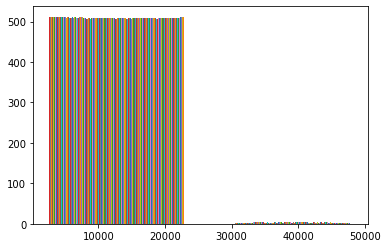

In [89]:
plt.hist(image_data, 2)
plt.show()

In [ ]:
#45 pixles are best for ytop, ybottom range 
